In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# def force_cudnn_initialization():
#     s = 32
#     dev = torch.device('cuda')
#     torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [3]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [4]:
train ={
         1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
      
   
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    },
 
}
test = {2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
     
   
}
appliances = ["Dish Washer"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 9
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.Tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [6]:
# import pandas as pd
# import jax.numpy as jnp
# from datetime import datetime
# from sklearn.preprocessing import StandardScaler
# import torch

# def dataset_load(appliances, train, test=None):
#     x_train = []
#     y_train = []
#     x_train_timestamp = []
#     scaler_x = StandardScaler()
#     scaler_y = StandardScaler()
#     scaler_time = StandardScaler()
#     # train
#     for key, values in train.items():
#         df = pd.read_csv(
#             f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
#         df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
#         startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
#         endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

#         if startDate > endDate:
#             raise "Start Date must be smaller than Enddate."

#         df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
#         df.dropna(inplace=True)
#         x = df["main"].values
#         y = df[appliances[0]].values
        
#         timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

#         x_train.extend(torch.tensor(x))
#         y_train.extend(torch.tensor(y))
#         x_train_timestamp.extend(torch.tensor(timestamp_train))

#     x_train = torch.tensor(x_train).reshape(-1, 1)
#     y_train = torch.tensor(y_train).reshape(-1, 1)
#     x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
#     x_train = scaler_x.fit_transform(x_train)
#     y_train = scaler_y.fit_transform(y_train)
#     x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


#     # test
#     x_test = []
#     y_test = []
#     x_test_timestamp = []
#     for key, values in test.items():
#         df = pd.read_csv(
#             f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
#         df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
#         startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
#         endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

#         if startDate > endDate:
#             raise "Start Date must be smaller than Enddate."

#         df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
#         df.dropna(inplace=True)
#         x = df["main"].values
#         y = df[appliances[0]].values
#         timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

#         x_test.extend(torch.tensor(x))
#         y_test.extend(torch.tensor(y))
#         x_test_timestamp.extend(timestamp)

#     x_test = torch.tensor(x_test).reshape(-1, 1)
#     y_test = torch.tensor(y_test).reshape(-1, 1)
#     x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

#     x_test = scaler_x.transform(x_test)
#     x_test_timestamp = scaler_time.transform(x_test_timestamp)

#     x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1).contiguous().to(torch.float64)
#     y_train = torch.tensor(y_train).reshape(-1,).contiguous().to(torch.float64)
#     x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1).contiguous().to(torch.float64)
#     x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1).contiguous().to(torch.float64)
#     y_test = torch.tensor(y_test).reshape(-1,).contiguous().to(torch.float64)
#     x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).contiguous().to(torch.float64)


#     return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y


In [7]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, scaler_x, scaler_y,scaler_time= dataset_load(appliances, train, test)

: 

: 

In [ ]:
# indexes =15000
n = 9
# x_train_full = jnp.concatenate((jnp.array(x_train.reshape(-1,n)), jnp.array(np.array(x_train_timstamp))), axis=1)
# x_test_full = jnp.concatenate((jnp.array(x_test.reshape(-1,n)), jnp.array(np.array(x_test_timestamp))), axis=1)
# x_train_full.shape, x_test_full.shape

x = torch.Tensor(np.array(x_train))
y = torch.Tensor(np.array(y_train)).reshape(-1)
xt = torch.Tensor(np.array(x_test))
yt = torch.Tensor(np.array(y_test)).reshape(-1)

# if x.shape[0]>indexes:
#   x1 = x[:indexes]
#   y1 = y[:indexes]

# xt1= x[indexes:]
# yt1 = y[indexes:]

In [ ]:
x.shape, xt.shape

(torch.Size([24918, 9]), torch.Size([15656, 9]))

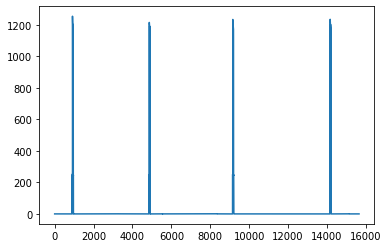

In [ ]:
plt.plot(yt)

In [13]:
data_dim = x.size(-1)
class LargeFeatureExtractor1(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor1, self).__init__()
        self.add_module('lstm', torch.nn.LSTM(data_dim, 256,4))
        # self.add_module('linear1', torch.nn.Linear(data_dim, 250))
        # self.add_module('relu1', torch.nn.ReLU())
        # self.add_module('linear2', torch.nn.Linear(250, 50))     
        # self.add_module('relu2', torch.nn.ReLU())                  
        # self.add_module('linear3', torch.nn.Linear(50, 9))       
        # self.add_module('relu3', torch.nn.ReLU())   
        # self.add_module('linear4', torch.nn.Linear(250, 100))       
        # self.add_module('relu4', torch.nn.ReLU())                         
        # self.add_module('linear5', torch.nn.Linear(100, 9))

class LargeFeatureExtractor2(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor2, self).__init__()
        # self.add_module('lstm', torch.nn.LSTM(data_dim, 500,2))
        # self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        # self.add_module('relu1', torch.nn.ReLU())
        # self.add_module('linear2', torch.nn.Linear(1000, 500))     
        # self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear1', torch.nn.Linear(256, 64))       
        self.add_module('relu1', torch.nn.ReLU())   
        self.add_module('linear2', torch.nn.Linear(64, 9))                          
        # self.add_module('linear1', torch.nn.Linear(200, 99))  

feature_extractor1 = LargeFeatureExtractor1().cuda()
feature_extractor2 = LargeFeatureExtractor2().cuda()

In [14]:
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.base_covar_module =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=9)) 
            #+ gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=(49)))*gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(ard_num_dims=1, active_dims=(49)))
            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            #     num_dims=2, grid_size=100
            # )
            self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[np.arange(0, train_x.shape[0], 25)], likelihood=likelihood)
            print(self.covar_module)
            self.feature_extractor1 = feature_extractor1
            self.feature_extractor2 = feature_extractor2

            # This module will scale the NN features so that they're nice values
            # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x, (hn,cn) = self.feature_extractor1(x)
            print(projected_x.shape, hn.shape,cn.shape)
            projected_x = self.feature_extractor2(projected_x)
            # print(projected_x.shape, hn.shape,cn.shape)
            # projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
            # print(projected_x.dtype)
            mean_x = self.mean_module(projected_x) #projected_
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(x, y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

InducingPointKernel(
  (base_kernel): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
)


In [38]:
import tqdm
training_iterations = 500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
loss_arr =[]
def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(x.cuda())
        # Calc loss and backprop derivatives
        loss = -mll(output, y.cuda())
        # loss_arr.append(loss.cpu())
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'dim'

In [55]:
# model_name = "DishWasher_deepkernel_rbf_building2_final.pt"
# torch.save(model.state_dict(), os.path.join(
#    "./final_models/", model_name))

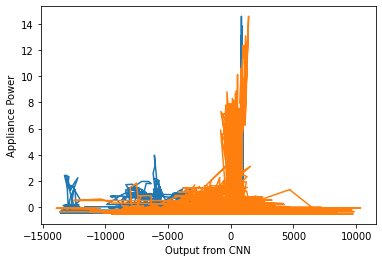

In [56]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(xt.cuda())

In [57]:
preds.mean

tensor([-0.1602, -0.1957, -0.2399,  ...,  0.1679,  0.1645,  0.1671],
       device='cuda:0')

In [58]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(scaler_y.inverse_transform(preds.mean.cpu().reshape(-1,1)).squeeze()) - yt))))

Test MAE: 38.03371716993423


In [151]:
#11.666734585865639
#Test MAE: 11.616466732809029

# Test MAE: 11.523664471266923 0.01lr, 60induce, 1dim, 230 epochs, cpu

In [152]:
y_mean = scaler_y.inverse_transform(preds.mean.cpu().reshape(-1,1)).squeeze()

In [153]:
y_mean

array([-0.46579305, -0.4623509 , -0.46649902, ...,  2.83267605,
        2.8319659 ,  2.82751144])

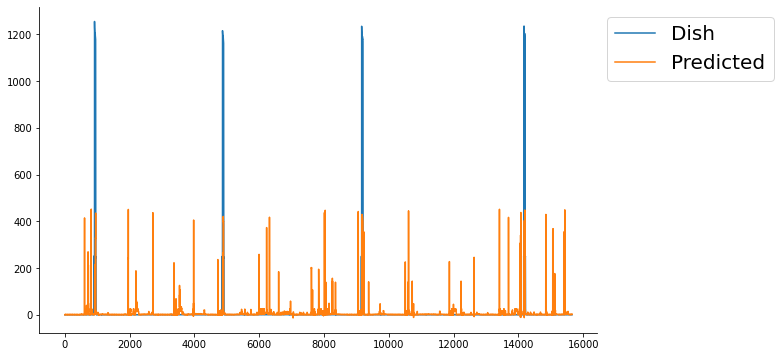

In [154]:
idx = xt.shape[0]
plt.figure(figsize=(10,6))
plt.plot(jnp.arange(idx),yt[:idx], label = "Dish")
plt.plot(jnp.arange(idx), y_mean[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
# plt.savefig("./Results/Refrigerator_building5.png", bbox_inches="tight")